# Matrix Multiplication From the Foundations

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Download Data

In [2]:
# Downloading the MNIST dataset with additional checks
MNIST_URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')

path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
# Double checking the location of download
!ls -l data

total 16656
-rw-r--r-- 1 bchaudhry bchaudhry 17051982 May 16 17:55 mnist.pkl.gz


In [5]:
# Loading the data as a tuple of tuples
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

We aren't allowed to use Numpy, Pandas, PyTorch this early on, we'll have to work with the standard Python toolkit.

In [7]:
lst_1 = list(x_train[0])
vals = lst_1[200:222]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98046875,
 0.36328125,
 0.3203125,
 0.3203125,
 0.21875,
 0.15234375,
 0.0,
 0.0,
 0.0]

In [8]:
len(lst_1)

784

Since we can't work with matrices at the moment, we will need to convert our list of 784 elements into lists of 28x28. To do that, we can use `chunks`

In [9]:
# Creating a function for chunks
def chunks(x, sz):
    # Loop through values from 0 to length of the list based on size
    # Yield(iterator) allows us to keep returning values till all elements in the
    # input have finished.

    # Note: yield returns outputs only from inside functions.
    for i in range(0, len(x), sz): yield x[i:i + sz]

In [10]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125],
 [0.98828125, 0.98828125, 0.98828125, 0.98046875, 0.36328125],
 [0.3203125, 0.3203125, 0.21875, 0.15234375, 0.0],
 [0.0, 0.0]]

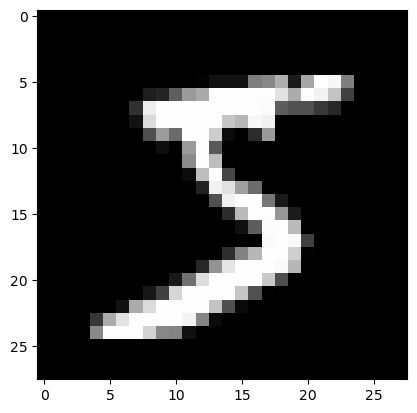

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst_1, 28)));

We can continue working with iterators using the library `itertools`

In [12]:
from itertools import islice

In [13]:
it = iter(vals)
islice(it, 5)

`islice` allows us to move through our data chunks based on the step value. Once there is no more data remaining in the chunks, it will return an empty list.

In [14]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [15]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [16]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98046875, 0.36328125]

In [17]:
list(islice(it, 5))

[0.3203125, 0.3203125, 0.21875, 0.15234375, 0.0]

In [18]:
list(islice(it, 5))

[0.0, 0.0]

In [19]:
list(islice(it, 5))

[]

In [20]:
it = iter(lst_1)
img = list(iter(lambda: list(islice(it, 28)), []))

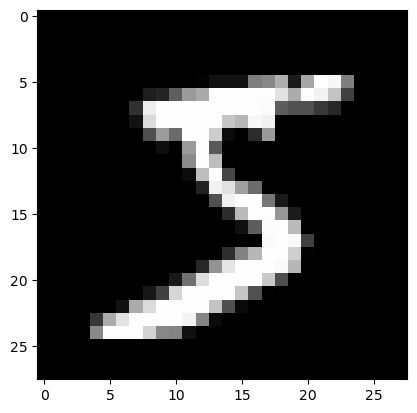

In [21]:
plt.imshow(img);

## Creating a Matrix and Tensor

In [22]:
# Indexing into an image for demo purposes
img[20][15]

0.98828125

In [23]:
# Let's create a class to work with matrices
# At first, this will only return the first and second indeces of an image
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [24]:
# Testing
m = Matrix(img)
m[20, 15]

0.98828125

We are now allowed to use the PyTorch `tensor` feature.

In [25]:
from torch import tensor

In [26]:
# Testing
tensor([1,2,3,4])

tensor([1, 2, 3, 4])

In [27]:
# Loading image to Tensor
tens = tensor(img)
tens.shape, tens[20, 15]

(torch.Size([28, 28]), tensor(0.9883))

In [28]:
# Mapping train and valid to a tensor
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [29]:
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

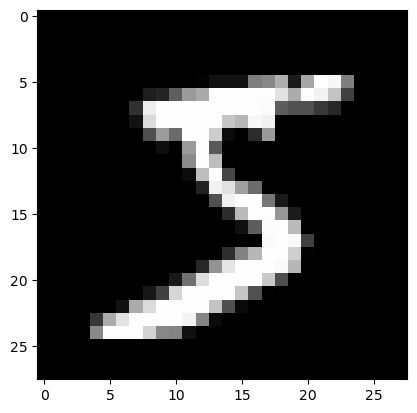

In [30]:
plt.imshow(imgs[0]);

In [31]:
# Indexing into our tensor
imgs[0, 20, 15]

tensor(0.9883)

In [32]:
num_imgs, cols = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [33]:
%time min(y_train), max(y_train)

CPU times: user 838 ms, sys: 5.32 ms, total: 844 ms
Wall time: 206 ms


(tensor(0), tensor(9))

In [34]:
%time y_train.min(), y_train.max()

CPU times: user 7.5 ms, sys: 779 μs, total: 8.27 ms
Wall time: 1.49 ms


(tensor(0), tensor(9))

## On Random Numbers

Although we can use the random number generator in Python, we will opt to do it the hard way. 

This is based on the **[Wichmann Hill](https://en.wikipedia.org/wiki/Wichmann%E2%80%93Hill)** algorithm:

> Wichmann–Hill is a pseudorandom number generator proposed in 1982 by Brian Wichmann and David Hill. It consists of three linear congruential generators with different prime moduli, each of which is used to produce a uniformly distributed number between 0 and 1. These are summed, modulo 1, to produce the result.

> Summing three generators produces a pseudorandom sequence with cycle exceeding 6.95×1012. Specifically, the moduli are 30269, 30307 and 30323, producing periods of 30268, 30306 and 30322. The overall period is the least common multiple of these: 30268×30306×30322/4 = 6953607871644. This has been confirmed by a brute-force search.

In [35]:
# Creating our custom pseudo random number generator
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x) + 1, int(y) + 1, int(z) + 1

In [36]:
# Testing
seed(91737649164947)
rnd_state

(15508, 3633, 9043)

In [37]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x, y, z
    return (x / 30269 + y / 30307 + z / 30323) % 1.0

In [38]:
rand(), rand(), rand()

(0.9260572151726816, 0.2761706728795734, 0.9273684118432157)

In [39]:
# Fork's a process, which returns 0 in the child and the child's process id
# in the parent. 
# Right now, we are seeing similar random numbers because both the parent and the child
# are copies of each other.
if os.fork(): 
    print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.6143809484183271
In child: 0.6143809484183271


Let's see whether our go to libraries correctly re-initialize the random stream in the forked versions.

In [40]:
# Checking PyTorch's version.
import torch
if os.fork(): 
    print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.6177])
In child: tensor([0.6177])


In [41]:
# Checking Numpy
import numpy as np
if os.fork(): 
    print(f'In parent: {np.random.rand(1)}')
else:
    print(f'In child: {np.random.rand(1)}')
    os._exit(os.EX_OK)

In parent: [0.6463992]
In child: [0.6463992]


In [42]:
# Checking base Python
from random import random
if os.fork(): 
    print(f'In parent: {random()}')
else:
    print(f'In child: {random()}')
    os._exit(os.EX_OK)

In parent: 0.790272760622809
In child: 0.7699271644729105


Python's implementation is the only one that gets it right!!

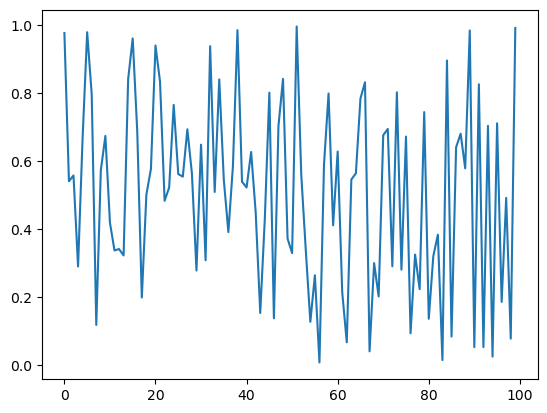

In [43]:
plt.plot([rand() for _ in range(100)]);

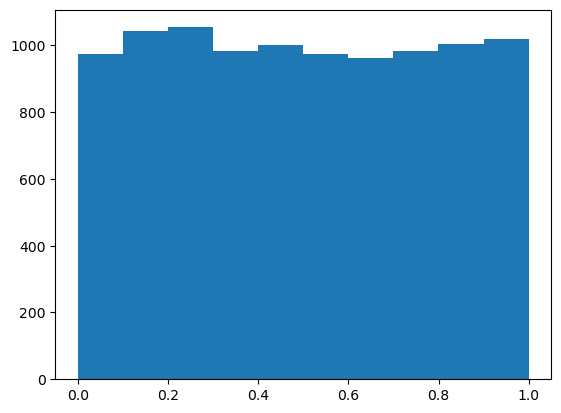

In [44]:
plt.hist([rand() for _ in range(10000)]);

In [45]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

1.58 ms ± 42.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 24.21 times longer than the fastest. This could mean that an intermediate result is being cached.
80.7 μs ± 151 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix Multiplication

In [47]:
# Change torch display settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [48]:
torch.manual_seed(1)
# Creating random numbers for the weights
weights = torch.randn(784, 10)
bias = torch.zeros(10)

`m1` will be a subset of the first 5 digits, on which we will carry out matrix multiplication operations.

In [49]:
m1 = x_valid[:5] # This will give us 5 rows of 5 images which have been flattened out.
m2 = weights

m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [50]:
ar, ac = m1.shape
br, bc = m2.shape

(ar, ac), (br, bc)

((5, 784), (784, 10))

Carrying out a matrix multiplication on `5x784` and `784x10` will give us a resulting tensor of `5x10` which is the outcome of multiplying and adding 784 pairs of digits.

In [51]:
# Creating an empty 5x10 tensor.
t1 = torch.zeros(ar, bc)
t1

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [52]:
t1.shape

torch.Size([5, 10])

Now, for the matrix multiplication itself, we will need to create nested loops which will add results of the matrix multiplication to the newly created tensor `t1`:
1. Loop through each row from `m1`
2. Loop through each column from `m2`
3. Loop through each pair from `m1` and `m2`

In [53]:
for i in range(ar): # Each row in m1       ----> 5
    for j in range(bc): # Each column in m2----> 10
        for k in range(ac): # Each pair    ----> 784
            t1[i, j] += m1[i, k] * m2[k, j]

In [54]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

Lets put this into a function

In [55]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape 
    # Creating an empty 5x10 tensor.
    c = torch.zeros(ar, bc)
    # Run multiplication loops
    for i in range(ar): # Each row in m1       ----> 5
        for j in range(bc): # Each column in m2----> 10
            for k in range(ac): # Each pair    ----> 784
                c[i, j] += a[i, k] * b[k, j]
    return c

In [56]:
%time _ = matmul(m1, m2)

CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 246 ms


That is unacceptably slow for just...

In [57]:
ar*bc*ac

39200

..items, imagine running this kind of function on hundreds of thousands or millions of images.

This is why we need to leverage libraries which can allow us to program in Python - but can compile our operations at considerably faster speeds.

## Introducing `Numba` 

In [58]:
from numba import njit

Based on the documentation, Numba is a JIT compiler for Python and is tailor made for code that utilizes NumPy arrays, functions and loops.

The use of decorators is the most common way to use Numba. **Once called, the Numba decorated code / function is compiled JIT at native machine code speed.**

For more details, visit the [documentation page](https://numba.pydata.org/numba-doc/latest/user/5minguide.html).

In [59]:
@njit
def dot(a, b):
    res = 0.
    for i in range(len(a)): res += a[i] * b[i] #Inner most loop from the previous section.
    return res

In [60]:
from numpy import array

In [61]:
%time dot(array([1., 2, 3]), array([2., 3, 4]))

CPU times: user 238 ms, sys: 8.04 ms, total: 246 ms
Wall time: 318 ms


20.0

By introducing these changes, we've brought CPU and Wall times down from ~270 ms to 29 microsecs. The first run, in this instance is slow and the reason for this is that Numba needs to compile our code on top of the execution for the first run. Notice how, the performance improves!

In [62]:
%time dot(array([1., 2, 3]), array([2., 3, 4]))

CPU times: user 14 μs, sys: 2 μs, total: 16 μs
Wall time: 16.2 μs


20.0

Let's alter the `matmul()` function to factor in the newly created `dot()` function.

In [63]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    # Create empty tensor
    c = torch.zeros(ar, bc)
    # Run updated loop
    for i in range(ar):
        for j in range(bc): c[i, j] = dot(a[i, :], b[:, j])
    return c           

In [64]:
m1a, m2a = m1.numpy(), m2.numpy()

In [65]:
# Let's use the FastAI library to test the performance improvements of this seemingly simple update.
from fastcore.test import *

In [66]:
test_close(t1, matmul(m1a, m2a))

In [67]:
test_close??

Signature: test_close(a, b, eps=1e-05)
Source:   
def test_close(a,b,eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a,b,partial(is_close,eps=eps),'close')
File:      ~/miniforge3/lib/python3.10/site-packages/fastcore/test.py
Type:      function

In [68]:
%timeit -n 50 matmul(m1a, m2a)

159 μs ± 18.8 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


By adding `@njit` to the third part of the matrix multiplication loop, we've effectively sped up the operation by around **2000x**

## Element-Wise Operations

This is a good place to introduce [APL (Array Programming Language)](https://tryapl.org/) which has

> ...a powerful, concise syntax, it lets you develop shorter programs that enable you to think more about the problem you're trying to solve than how to express it to a .

The code below, for element-wise operations was first tested in the APL interface and then applied in Python.

In [69]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [70]:
a + b

tensor([12., 14.,  3.])

In [71]:
a < b

tensor([False,  True,  True])

An interesting fact that Jeremy shared was that there is no function for `mean` in APL. The language allows users to define such operations themselves and he used the following code to define the function:

> **mean <- +/÷≢**


In [72]:
# Taking the mean of the binary results above, which we've already tested in APL
(a < b).float().mean()

tensor(0.67)

What is _even more interesting_ is the fact that we can carry out pretty much any kind of mathematical operation in APL. Just take the example of creating a 3x3 matrix below:

> m ← 3 3 ⍴ ⍳9

which is pretty awesome, considering that the output is the same as the PyTorch version below.

In [73]:
m = tensor([[1., 2, 3], [4., 5, 6], [7., 8, 9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Lets introduce the concept of Froebenius Norm, which is:

> The Frobenius norm, sometimes also called the Euclidean norm (a term unfortunately also used for the vector L^2-norm), is matrix norm of an `m×n` matrix A defined as the square root of the sum of the absolute squares of its elements...The Frobenius Norm can also be considered as a vector norm and is expressed as:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In code, this boils down to...

In [74]:
sf = (m * m).sum()
sf

tensor(285.)

In [75]:
sf.sqrt()

tensor(16.88)

And to implement this in APL, we can take the matrix `m` which we created earlier, followed by:
> sf <- +/,m*m
> sf*0.5

We need to multiply `sf` with 0.5 since APL doesn't have a square-root function.

With this additional knowledge, we can alter the `matmul()` even further by carrying out element-wise dot products.

In [76]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [77]:
test_close(t1, matmul(m1, m2))

In [78]:
%timeit -n 50 _ = matmul(m1, m2)

332 μs ± 9.15 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Which is slower than the Numba implementation, but orders of magnitude faster than the first version of `matmul()`. Lets see what using `torch.dot()` yeilds in terms of performance improvements.

In [79]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i, j] = torch.dot(a[i, :], b[:, j])
    return c

In [80]:
test_close(t1, matmul(m1, m2))

In [81]:
%timeit -n 50 _ = matmul(m1, m2)

292 μs ± 14.5 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


This is still slower than Numba!

## Broadcasting

### Broadcasting with a Scalar

In [82]:
a

tensor([10.,  6., -4.])

In [83]:
a > 0

tensor([ True,  True, False])

In [84]:
# Which is the same as 
a > tensor([0., 0, 0])

tensor([ True,  True, False])

In [85]:
# Simple operations
a + 1

tensor([11.,  7., -3.])

In [86]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [87]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcast a Vector to a Matrix

In [88]:
# Creating a rank 1 tensor
c = tensor([10, 20, 30])
c

tensor([10, 20, 30])

In [89]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [90]:
# Matrices can be added together
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [91]:
# This also works both ways
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

These operations come from a slightly obscure concept called `expand_as()` which expands a tensor to the given size of another tensor.

In [92]:
# Our 1x3 tensor expands to a 3x3 shape
t = c.expand_as(m)
t 

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

In [93]:
torch.Tensor.expand_as?

Docstring:
expand_as(other) -> Tensor

Expand this tensor to the same size as :attr:`other`.
``self.expand_as(other)`` is equivalent to ``self.expand(other.size())``.

Please see :meth:`~Tensor.expand` for more information about ``expand``.

Args:
    other (:class:`torch.Tensor`): The result tensor has the same size
        as :attr:`other`.
Type:      method_descriptor

In [94]:
# We can check what resides in memory
t.storage()

 10
 20
 30
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 3]

In [95]:
# Stride is the jump necessary to move to the next element
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

We can index with the special value `None`. Alternatively, `unsqueeze()` also converts a 1-dimensional array into a 2-dimensional array (with one of the dimensions having the value 1).

Using `None` is more flexible than the `unsqueeze()` method.

In [96]:
c.unsqueeze(0), c[None, :]

(tensor([[10, 20, 30]]), tensor([[10, 20, 30]]))

In [97]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [98]:
# Output one row with a new unit axis
c.unsqueeze(1), c[:, None]

(tensor([[10],
         [20],
         [30]]),
 tensor([[10],
         [20],
         [30]]))

In [99]:
# Triple dots will always insert a unit axis in a tensor, regardless of rank.
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [100]:
# Another way to look at the expand_as() function.
c[:, None].expand_as(m)

tensor([[10, 10, 10],
        [20, 20, 20],
        [30, 30, 30]])

In [101]:
# Orientations of mathematical operations can be modified based on the above
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [102]:
# A simple flip changes the orientation of the sum.
m + c[None, :]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

Two dimensions are equal when:
1. They are equal or,
2. one of them is 1, which means the dimension is broadcasted to make it the same size.

Also, arrays do not need to have the same number of dimensions in order for them to be able to interact with each other.

In [103]:
c[None, :], c[None, :].shape

(tensor([[10, 20, 30]]), torch.Size([1, 3]))

In [104]:
c[:, None], c[:, None].shape

(tensor([[10],
         [20],
         [30]]),
 torch.Size([3, 1]))

In [105]:
# This results in an outer product
c[None, :] * c[:, None]

tensor([[100, 200, 300],
        [200, 400, 600],
        [300, 600, 900]])

In [106]:
# Outer boolean operations
c[None, :] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

## Matmul with Broadcasting

We can now apply what we've learned about broadcasting to further speed up `matmul()`.

So, now we can grab a single digit which is a 784x1 matrix. Using `expand_as()` on digit will give us the same shape as out weight matrix. We can then multiply both matrices to get a 784x10 result.

In [107]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [108]:
digit[:, None].shape

torch.Size([784, 1])

In [109]:
digit[:, None].expand_as(m2).shape

torch.Size([784, 10])

In [110]:
(digit[:, None] * m2).shape

torch.Size([784, 10])

Using this approach, we can add broadcasting to the `matmul()` function.

In [111]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        # Take the ith row, all the cols and add an axis at the end
        # then multiply by b and sum it up
        c[i] = (a[i, :, None] * b).sum(dim=0)
    return c

In [112]:
test_close(t1, matmul(m1, m2))

In [113]:
%timeit -n 50 _ = matmul(m1, m2)

45.2 μs ± 3.21 μs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Let's test this out on the whole dataset, instead of just a mini-batch

In [114]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [115]:
tr.shape

torch.Size([50000, 10])

In [116]:
%time _ = matmul(x_train, weights)

CPU times: user 2.26 s, sys: 54.8 ms, total: 2.31 s
Wall time: 499 ms


## Einstein Summation

Compact representations of mathematical operations, like Einstein Summation, allow us to achieve considerable speed improvements over standard approaches. As this [blog](https://ajcr.net/Basic-guide-to-einsum/) states:

> The einsum function is one of NumPy’s jewels. It can often outperform familiar array functions in terms of speed and memory efficiency, thanks to its expressive power and smart loops. On the downside, it can take a little while understand the notation and sometimes a few attempts to apply it correctly to a tricky problem.

In [117]:
# Going back to our m1 and m2 tensors
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In the notation below:
- `i` is 5
- `k` is 784
- `j` is 10

The resulting vector is 5x784x10, which is:
- The original 5 rows of m1.
- The original 10 columns of m2.
- The 784 dimension is common to m1 and m2

In [118]:
# using Einsum notation in torch, and btw this also applies to Numpy
mr = torch.einsum('ik,kj -> ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [119]:
# Summing up
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

An interesting point to note is that omitting a letter from the output means that values along that axis will be summed. So, that allows us to further simplify the code.

In [120]:
# Case in point
torch.einsum('ik,kj -> ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [121]:
# Rewriting the matmul function
def matmul(a,b):
    return torch.einsum('ik,kj->ij', a, b)

In [122]:
# Running test close to check if the einsum result is equal to the original
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [123]:
%timeit -n 5 _ = matmul(x_train, weights)

10.7 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Which is considerably faster that even the broadcasting approach.

## PyTorch Operator

We can also use PyTorch's function / operator for matrix multiplication operations. The result, at least for this dataset is around the same as the Einsum implementation.

In [124]:
test_close(tr, x_train@weights, eps=1e-3)

In [125]:
%timeit -n 5 _ = torch.matmul(x_train, weights)

11.5 ms ± 727 μs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA - for warp speed!!

The beauty of parallel processing, using CUDA, is that we can define self contained functions which won't interact with any other operations.

We can build some intuition by rewriting the matmul() function to fill in only one number in a tensor. This effectively converts our matmul() into a kernel.

In [127]:
# This version takes in an additional parameter called 'grid', which allows us to
# set the location (using coordinates) of the single output.
def matmul(grid, a, b, c):
    # Grid inputs, should be inside the bounds of the output tensor
    i, j = grid
    if i < c.shape[0] and j < c.shape[1]:
        # Start at 0
        tmp = 0.
        # Loop through all of the columns of a and the rows of b for i and j
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i, j] = tmp

In [128]:
res = torch.zeros(ar, bc)
# Run a matmul calculation and the output should be added to coordinates (0,0)
matmul((2, 3), m1, m2, res)
res

tensor([[ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00, -6.05,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00]])

Now, we need to launch the kernel and pass in the key parameters of the tensor grid.

In [129]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    # Loop through the rows of a
    for i in range(grid_x):
        # Loop through the columns of b
        for j in range(grid_y): kernel((i, j), *args, **kwargs) # Unpack as 3 separate args

In [130]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

Now that we have some intuition around this topic let's actually do it in parallel.

In [131]:
from numba import cuda

In [132]:
# Rewriting the njit version of matmul() using cuda.
# This implementation has just one small variation compared to the original.
# The decorator compiles the following into GPU code.
@cuda.jit 
def matmul(a, b, c):
    # We call the grid here, specifying the number of dimensions 
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i, j] = tmp

In [133]:
# Lets make sure that the local gpu is working properly
# Peak wattage should be lower since we're using the standard ASUS profile.
!nvidia-smi

Tue Jul 16 16:02:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0             13W /   99W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [134]:
r = np.zeros(tr.shape) # output tensor
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r)) # 3 items to be copied to gpu

In [135]:
r.shape

(50000, 10)

In [136]:
TPB = 16 # Threads per block.
rr, rc = r.shape
blocks_per_grid = (math.ceil(rr / TPB), math.ceil(rc / TPB)) # Operations assigned to blocks
blocks_per_grid

(3125, 1)

For CUDA JIT to work, we need to add [] brackets in the next cell, which contains the `blocks_per_grid` result from the last cell and the TPB as well.

In [137]:
matmul[blocks_per_grid, (TPB, TPB)](m1g, m2g, rg) # This launches the kernel
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [138]:
%%timeit -n 10
matmul[blocks_per_grid, (TPB, TPB)](m1g, m2g, rg)
r = rg.copy_to_host()

6.92 ms ± 613 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Quite an improvement here. And different gaming profiles have a direct impact on the speed of calculations. For reference, I haven't enabled the "Ultimate" GPU mode.

We can go even faster by using PyTorch ops.

In [139]:
# Copying tensors over to the GPU
m1c, m2c = x_train.cuda(), weights.cuda()

In [140]:
r = (m1c @ m2c).cpu() # copying operations to the host

In [141]:
%timeit -n 10 r = (m1c @ m2c).cpu()

1.31 ms ± 280 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The final version is close to 5 million times faster than the original version.